In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import statsmodels.formula.api as smf
import statsmodels.api as sm

### Informative scores across perturbed pathways

In [130]:
data2 = pd.read_csv('../results/benchmark/z_scores/progeny/single/KEGG_filtered_abs.csv',
                  sep=',', header=0, index_col=0)
data1 = pd.read_csv('../results/benchmark/z_scores/progeny/single/BEST_dorothea_AB_filtered_abs.csv',
                   sep=',', header=0, index_col=0)

In [131]:
data1['Gene set'] = data1.index
data1 = pd.melt(data1, id_vars='Gene set', value_vars=data1.columns[:-1], var_name='Perturbed pathway', 
       value_name='Informative score')
data2['Gene set'] = data2.index
data2 = pd.melt(data2, id_vars='Gene set', value_vars=data2.columns[:-1], var_name='Perturbed pathway', 
       value_name='Informative score')
data1['Database'] = 'DoRothEA'
data2['Database'] = 'KEGG'
data = pd.concat([data1, data2])
data['Informative score'] = data['Informative score'].abs()

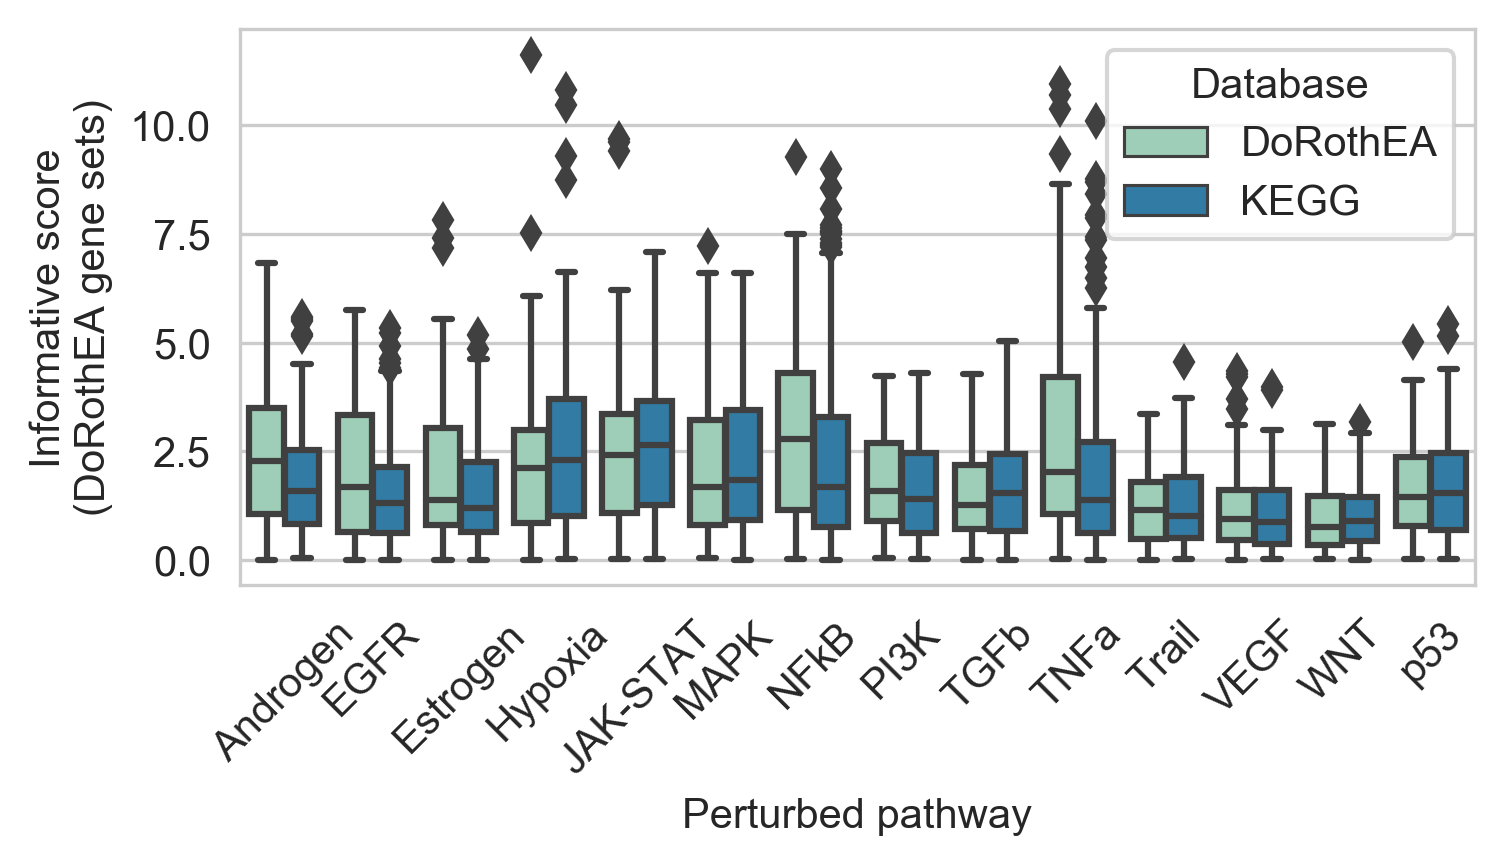

In [133]:
plt.figure(figsize=(5,3), dpi=300)
sns.set_palette('YlGnBu', 2)
sns.boxplot(x=data['Perturbed pathway'], y=data['Informative score'], hue=data['Database'])
plt.ylabel('Informative score\n(DoRothEA gene sets)')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('../figures/revision/scores_perturbation.png')

In [139]:
data.columns = ['Gene_set', 'Perturbed_pathway','Informative_score', 'Database']

In [141]:
model = smf.ols('Informative_score ~ Database * Perturbed_pathway', data=data).fit()

In [142]:
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Database,1.0,29.139363,29.139363,13.524107,2.385886e-04
Perturbed_pathway,13.0,1091.223624,83.940279,38.958206,7.821004e-94
Database:Perturbed_pathway,13.0,116.738473,8.979883,4.167726,6.314308e-07
Residual,4032.0,8687.443315,2.154624,NaN,NaN


### TF mutations in GDSC benchmark data

In [154]:
data = pd.read_csv('../results/benchmark/z_scores/gdsc/single/BEST_dorothea_AB_filtered.csv',
                  sep=',', header=0, index_col=0)

In [155]:
mutations = pd.Series(data.columns).apply(lambda x: x.split('_')[0])

In [156]:
tfs = pd.read_csv('../results/genesets/single/csvs/dorothea_ABCDE.csv', sep=',', header=0, index_col=0)

/Users/benceszalai/opt/anaconda3/envs/pycharm/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [157]:
len(set(tfs['Set']) & set(mutations))

27

In [158]:
len(mutations)

172

### Similarity between gene sets

In [3]:
from scipy.stats import mannwhitneyu as mwu

In [13]:
def make_similarity_distribution(fname,dname1='BEST_dorothea_AB',metric='jaccard',force_ylim=False):
    similarities=pd.DataFrame(columns=['Database','Similarity','Random'])
    dnames = ['BEST_dorothea_AB', 'BEST_dorothea_CD', 'KEGG','BIOCARTA','REACTOME','CGP']
    dnames.remove(dname1)
    for dname2 in dnames:
        #readl
        if dname1 < dname2:
            data=pd.read_csv('../results/similarity/%s_filtered_%s_filtered_%s.csv' % (dname1,dname2,metric),
                             sep=',',header=0,index_col=0)
            data=data.max(1).values
        else: 
            data=pd.read_csv('../results/similarity/%s_filtered_%s_filtered_%s.csv' % (dname2,dname1,metric),
                             sep=',',header=0,index_col=0)
            data=data.max(0).values
        max_sim1=pd.DataFrame(index=range(len(data)),columns=similarities.columns)
        max_sim1['Database']=dname2
        max_sim1['Similarity']=data
        max_sim1['Random']='Actual gene set'
        similarities=pd.concat([similarities,max_sim1])
        #random
        if dname1 < dname2:
            data=pd.read_csv('../results/similarity/%s_random_dist_0_%s_random_dist_0_%s.csv' % (dname1,dname2,metric),
                             sep=',',header=0,index_col=0)
            data=data.max(1).values
        else:
            data=pd.read_csv('../results/similarity/%s_random_dist_0_%s_random_dist_0_%s.csv' % (dname2,dname1,metric),
                             sep=',',header=0,index_col=0)
            data=data.max(0).values
        max_sim2=pd.DataFrame(index=range(len(data)),columns=similarities.columns)
        max_sim2['Database']=dname2
        max_sim2['Similarity']=data
        max_sim2['Random']='Random gene set'
        similarities=pd.concat([similarities,max_sim2])

        print(dname1,dname2,mwu(max_sim1['Similarity'],max_sim2['Similarity']))
    sns.set_palette('YlGnBu',2)
    plt.figure(figsize=(4,3),dpi=300)
    similarities.columns = ['Database', 'Similarity', 'Gene set']
    sns.boxplot(x='Database',y='Similarity',hue='Gene set',data=similarities,)
    if metric=='jaccard':
        plt.ylabel('Jaccard index', size=15)
    else:
        plt.ylabel('Overlap coefficient', size=15)
    plt.xlabel('Database', size=15)
    if force_ylim:
        plt.ylim(0,1.0)
    plt.tight_layout()
    if fname:
        plt.savefig('../figures/raw/'+fname)

CGP BEST_dorothea_AB MannwhitneyuResult(statistic=3361123.0, pvalue=1.6938538028262095e-46)
CGP BEST_dorothea_CD MannwhitneyuResult(statistic=3130675.5, pvalue=1.9154280157178817e-71)
CGP KEGG MannwhitneyuResult(statistic=2987038.0, pvalue=9.005593393143206e-90)
CGP BIOCARTA MannwhitneyuResult(statistic=3642375.5, pvalue=1.7044114194514974e-23)
CGP REACTOME MannwhitneyuResult(statistic=2805165.0, pvalue=4.681942737152643e-116)


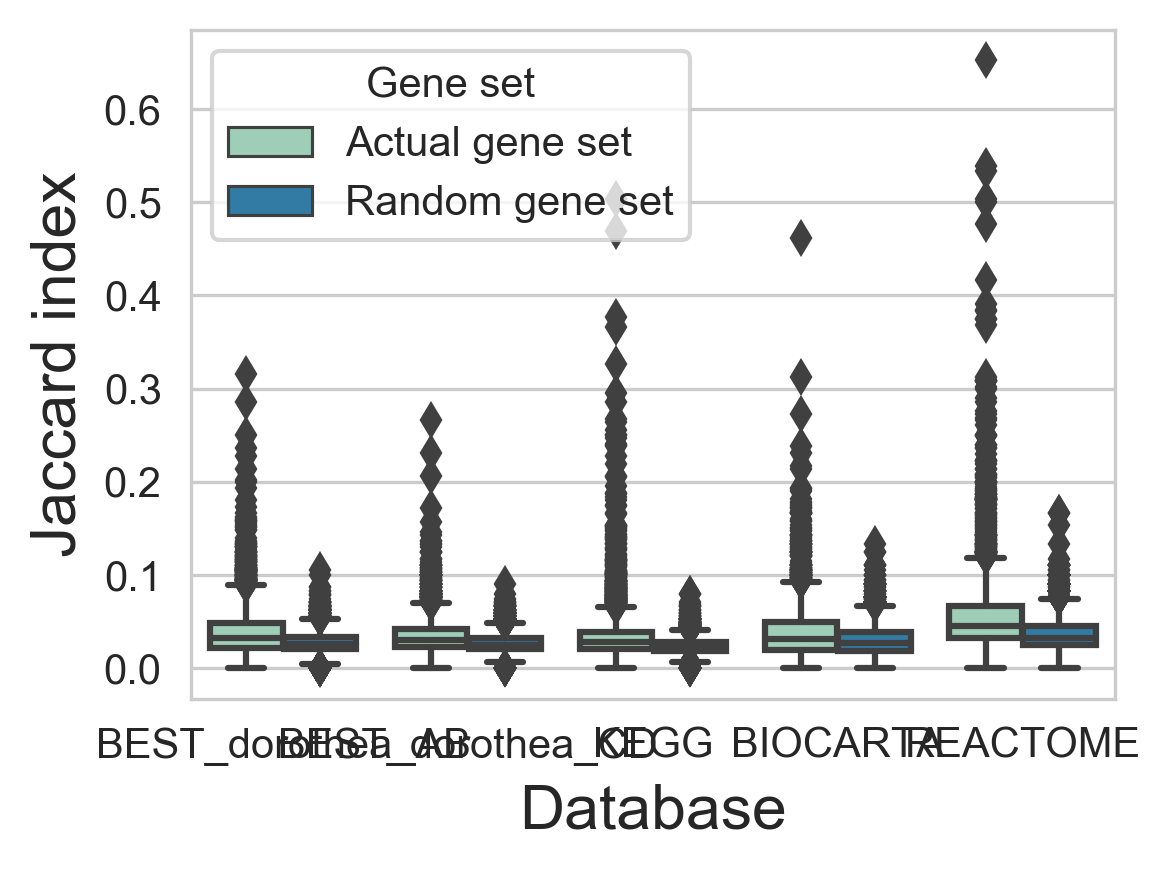

In [16]:
dname1='CGP'
metric='jaccard'
make_similarity_distribution(False, dname1, metric,)

In [11]:
dname1 = 'KEGG'
dname2 = 'CGP'
metric = 'jaccard'
data=pd.read_csv('../results/similarity/%s_filtered_%s_filtered_%s.csv' % (dname2,dname1,metric),
                             sep=',',header=0,index_col=0)

In [12]:
data

,KEGG_ABC_TRANSPORTERS,KEGG_ACUTE_MYELOID_LEUKEMIA,KEGG_ADHERENS_JUNCTION,KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY,KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM,KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION,KEGG_ALLOGRAFT_REJECTION,KEGG_ALPHA_LINOLENIC_ACID_METABOLISM,KEGG_ALZHEIMERS_DISEASE,KEGG_AMINOACYL_TRNA_BIOSYNTHESIS,...,KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY,KEGG_UBIQUITIN_MEDIATED_PROTEOLYSIS,KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_BIOSYNTHESIS,KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION,KEGG_VASCULAR_SMOOTH_MUSCLE_CONTRACTION,KEGG_VASOPRESSIN_REGULATED_WATER_REABSORPTION,KEGG_VEGF_SIGNALING_PATHWAY,KEGG_VIBRIO_CHOLERAE_INFECTION,KEGG_VIRAL_MYOCARDITIS,KEGG_WNT_SIGNALING_PATHWAY
Set,,,,,,,,,,,,,,,,,,,,,
ABBUD_LIF_SIGNALING_1_DN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.014286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ABBUD_LIF_SIGNALING_1_UP,0.000000,0.010101,0.008696,0.028037,0.0,0.000000,0.0,0.0,0.004831,0.000000,...,0.000000,0.005682,0.0,0.011628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ABBUD_LIF_SIGNALING_2_DN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ABBUD_LIF_SIGNALING_2_UP,0.000000,0.000000,0.011905,0.000000,0.0,0.018868,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ABDELMOHSEN_ELAVL4_TARGETS,0.000000,0.000000,0.022989,0.000000,0.0,0.000000,0.0,0.0,0.005556,0.000000,...,0.016393,0.000000,0.0,0.000000,0.007692,0.000000,0.010989,0.000000,0.011765,0.006061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWANG_CLASS_3_TRANSIENTLY_INDUCED_BY_EGF,0.000000,0.006969,0.009934,0.010135,0.0,0.000000,0.0,0.0,0.007614,0.000000,...,0.008902,0.005495,0.0,0.000000,0.000000,0.000000,0.006536,0.007042,0.006667,0.002625
ZWANG_EGF_INTERVAL_DN,0.000000,0.003413,0.003236,0.000000,0.0,0.003597,0.0,0.0,0.007519,0.000000,...,0.002907,0.002703,0.0,0.000000,0.002849,0.000000,0.003205,0.000000,0.000000,0.007812
ZWANG_EGF_INTERVAL_UP,0.000000,0.000000,0.000000,0.005747,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.005650,0.000000
